In [1]:
from __future__ import print_function

import math
import numpy as np
import pandas as pd
import json
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

from collections import Counter

/root/notebooks/anaconda3/envs/clip/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from itertools import product

import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import (CenterCrop, Compose, InterpolationMode,
                                    Normalize, RandomHorizontalFlip,
                                    RandomPerspective, RandomRotation, Resize,
                                    ToTensor)
from torchvision.transforms.transforms import RandomResizedCrop
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

BICUBIC = InterpolationMode.BICUBIC
from model.dfsp import DFSP
from parameters import parser, YML_PATH
from utils import *


seed = 1

In [3]:
from model.common import *
from test import *
from test import test
from tqdm import tqdm
import heapq

In [4]:
from dataset import CompositionDataset

In [5]:
dataset_path = '../OADis/OADis/path/to/mitstates'

In [6]:
train_dataset = CompositionDataset(dataset_path,
                                   phase='train',
                                   split='compositional-split-natural')

val_dataset = CompositionDataset(dataset_path,
                                 phase='val',
                                 split='compositional-split-natural')

# test_dataset = CompositionDataset(dataset_path,
#                                    phase='test',
#                                    split='compositional-split-natural',
#                                  open_world=True)

# train pairs: 1262 | # val pairs: 600 | # test pairs: 800
# train images: 30338 | # val images: 10420 | # test images: 12995
# train pairs: 1262 | # val pairs: 600 | # test pairs: 800
# train images: 30338 | # val images: 10420 | # test images: 12995


In [7]:
str(len(train_dataset.pairs))

'1962'

In [8]:
batch = train_dataset.__getitem__(0)

### 建立 DFSP

In [9]:
allattrs = train_dataset.attrs
allobj = train_dataset.objs
classes = [cla.replace(".", " ").lower() for cla in allobj]
attributes = [attr.replace(".", " ").lower() for attr in allattrs]
offset = len(attributes)

In [10]:
class config():
    def __init__(self):
        self.K=1 
        self.SA_K=1
        self.att_obj_w=0.01
        self.attr_dropout=0.3
        self.best_model_metric='best_unseen'
        self.bias=0.001
        self.clip_model='ViT-L/14'
        self.context_length=8
        self.dataset='mit-states'
        self.dataset_path='../OADis/OADis/path/to/mitstates'
        self.epoch_start=0
        self.epochs=20
        self.eval_batch_size=256
        self.fusion='txt2img'
        self.gradient_accumulation_steps=2
        self.load_model='data/model/mit-states/dfsp/txt2img_best.pt'
        self.lr=0.0001
        self.open_world=True
        self.prompt_template='a photo of x x'
        self.res_w=0.8
        self.save_every_n=5
        self.save_model=False
        self.save_path='data/model/mit-states/dfsp'
        self.seed=0
        self.sp_w=0.1
        self.text_encoder_batch_size=36
        self.threshold=0.4
        self.threshold_trials=50
        self.topk=1
        self.train_batch_size=128
        self.weight_decay=1e-05
        self.width_img=1024
        self.width_txt=768

In [12]:
con=config()

### 建立DFSP model

In [13]:
DFSP_model = DFSP(con, attributes=attributes, classes=classes, offset=offset).cuda()
# DFSP_model.load_state_dict(torch.load('data/model/mit-states/dfsp/txt2img_best.pt'))

### 建立all_fv_proj_idx

In [16]:
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
attr2idx = train_dataset.attr2idx
obj2idx = train_dataset.obj2idx

train_pairs = torch.tensor([(attr2idx[attr], obj2idx[obj])
                            for attr, obj in train_dataset.train_pairs]).cuda()

In [17]:
all_fv_proj_idx = []
for i in range(245):
    fv_proj_idx = 0
    fv_proj_idx = torch.Tensor().cuda()
    for obj_idx in range(len(train_pairs)):
        if train_pairs[obj_idx][1] ==i:
            fv_proj_idx = torch.cat([fv_proj_idx, train_pairs[obj_idx]], dim=0)
    fv_proj_idx=fv_proj_idx.reshape(-1,2)
    all_fv_proj_idx.append(fv_proj_idx)


In [23]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

DFSP_model.train()
best_loss = 1e5
best_metric = 0



train_losses = []
k=0
for i in range(con.epoch_start, con.epochs):
#     progress_bar = tqdm.tqdm(
#         total=len(train_dataloader), desc="epoch % 3d" % (i + 1)
#     )

    epoch_train_losses = []
    for bid, batch in enumerate(train_dataloader):

        batch_img = batch[0].cuda()
#             predict = model(batch_img, train_pairs)
        predict = DFSP_model(batch_img, train_pairs,True,batch[2],all_fv_proj_idx=all_fv_proj_idx)  ###更改批量計算
        k=k+1
        if k ==2:
            break
    if k ==2:
            break

2555
2555


In [26]:
predict[4].size()

torch.Size([8, 115])

### 開始預測

In [15]:
def predict_logits(model, dataset, config,all_fv_proj_idx):
    """Function to predict the cosine similarities between the
    images and the attribute-object representations. The function
    also returns the ground truth for attributes, objects, and pair
    of attribute-objects.

    Args:
        model (nn.Module): the model
        text_rep (nn.Tensor): the attribute-object representations.
        dataset (CompositionDataset): the composition dataset (validation/test)
        device (str): the device (either cpu/cuda:0)
        config (argparse.ArgumentParser): config/args

    Returns:
        tuple: the logits, attribute labels, object labels,
            pair attribute-object labels
    """
    model.eval()
    all_attr_gt, all_obj_gt, all_pair_gt = (
        [],
        [],
        [],
    )
    all_img_path = []
    
    attr2idx = dataset.attr2idx
    obj2idx = dataset.obj2idx
    # print(text_rep.shape)
    pairs_dataset = dataset.pairs
    pairs = torch.tensor([(attr2idx[attr], obj2idx[obj])
                                for attr, obj in pairs_dataset]).cuda()
    dataloader = DataLoader(
        dataset,
        batch_size= 128,
        shuffle=False)
    all_logits = torch.Tensor()
    loss = 0
    all_logits_attr_org = torch.Tensor()
    all_logits_attr_our = torch.Tensor()
#     all_fv_proj_idx =construct_all_fv_proj_idx(dataset,pairs)
    i = 0
    with torch.no_grad():
        for idx, data in tqdm(
            enumerate(dataloader), total=len(dataloader), desc="Testing"
        ):
            batch_img = data[0].cuda()
#             predict = model(batch_img, pairs)
#             predict = model(batch_img, pairs,True,data[2][0],all_fv_proj_idx=all_fv_proj_idx) ##這個是一張一張算
            predict = model(batch_img, pairs,True,data[2],all_fv_proj_idx=all_fv_proj_idx)  ###更改批量計算
            logits = predict[0]
#             loss += loss_calu(predict, data, config)
            attr_truth, obj_truth, pair_truth = data[1], data[2], data[3]
            logits = logits.cpu()
            #------------------------------
            logits_attr_org,logits_attr_our= predict[1].cpu(),predict[4].cpu()
            all_logits_attr_org = torch.cat([all_logits_attr_org, logits_attr_org], dim=0)
            all_logits_attr_our = torch.cat([all_logits_attr_our, logits_attr_our], dim=0)
            logits_attrs_list = [all_logits_attr_org,all_logits_attr_our]
            #------------------------------
            all_logits = torch.cat([all_logits, logits], dim=0)
            all_attr_gt.append(attr_truth)
            all_obj_gt.append(obj_truth)
            all_pair_gt.append(pair_truth)
            all_img_path = all_img_path + list(data[4])
            i = i +1
#             if i == 2:
#                 break

    all_attr_gt, all_obj_gt, all_pair_gt = (
        torch.cat(all_attr_gt).to("cpu"),
        torch.cat(all_obj_gt).to("cpu"),
        torch.cat(all_pair_gt).to("cpu"),
    )

    return all_logits, all_attr_gt, all_obj_gt, all_pair_gt,logits_attrs_list,all_img_path

In [16]:
def test(
        test_dataset,
        logits_attrs_list, ###新增
        evaluator,
        all_logits,
        all_attr_gt,
        all_obj_gt,
        all_pair_gt,
        config):
    ###----------------新增預測att--------------
    attr2idx = test_dataset.attr2idx
    obj2idx = test_dataset.obj2idx
    pairs_dataset = test_dataset.pairs
    pairs = torch.tensor([(attr2idx[attr], obj2idx[obj])
                                for attr, obj in pairs_dataset]).cuda()
    #-----------------------------------------
    att_ped_org = torch.argmax(logits_attrs_list[0],dim=1)
    att_ped_our = torch.argmax(logits_attrs_list[1],dim=1)
    ###---------------------------------------
    predictions = {
        pair_name: all_logits[:, i]
        for i, pair_name in enumerate(test_dataset.pairs)
    }
    all_pred = [predictions]

    all_pred_dict = {}
    for k in all_pred[0].keys():
        all_pred_dict[k] = torch.cat(
            [all_pred[i][k] for i in range(len(all_pred))]
        ).float()

    results = evaluator.score_model(
        all_pred_dict, all_obj_gt, bias=1e3, topk=1
    )


    attr_acc_ep1 = float(torch.mean(
        (results['unbiased_closed'][0].squeeze(-1) == all_attr_gt).float()))   ##先計算原本的attr 和obj acc
    obj_acc = float(torch.mean(
        (results['unbiased_closed'][1].squeeze(-1) == all_obj_gt).float()))
        ###----------------新增預測att--------------    
    results['unbiased_closed_our'] = (att_ped_our).unsqueeze(1).clone(),results['unbiased_closed'][1]

    attr_acc_ep2 = float(torch.mean(
        (results['unbiased_closed_our'][0].squeeze(-1) == all_attr_gt).float()))
        ###----------------新增預測att--------------
        ###----使用簡單學習-----------
    b,n_attr =  logits_attrs_list[1].size()
    final_pred = torch.zeros(b, dtype=torch.long)
    pred_ep1,pred_ep2 = results['unbiased_closed'][0].squeeze(-1).float(), logits_attrs_list[1].argmax(dim=1).float() 

    votes = torch.stack([pred_ep1, pred_ep2], dim=0)
    majority_vote, _ = torch.mode(votes, dim=0)
    correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
    attr_acc_sim_vote = correct_majority_vote / b
    
    ####集成學習
    for i in range(b):
        if pred_ep1[i] == pred_ep2[i]:
            final_pred[i] = pred_ep1[i]
        else:
            final_pred[i] = pred_ep1[i] if attr_acc_ep1 > attr_acc_ep2 else pred_ep2[i]

    # 计算投票后的准确率
    attr_acc_vote = (final_pred == all_attr_gt).sum().item() / b

    stats = evaluator.evaluate_predictions(
        results,
        all_attr_gt,
        all_obj_gt,
        all_pair_gt,
        all_pred_dict,
        topk=1,
    )
###----------------新增預測att--------------
    stats['attr_acc_ep2'] = attr_acc_ep2
#     stats['attr_acc_ep1'] = attr_acc_ep1 
    stats['attr_acc_vote'] = attr_acc_vote
    stats['attr_acc_sim_vote'] = attr_acc_sim_vote
###----------------新增預測att--------------
    stats['attr_acc_ep1'] = attr_acc_ep1
    stats['obj_acc'] = obj_acc   ###原本論文中的acc


    return stats

In [17]:
print('evaluating on the test set')
with torch.no_grad():
    evaluator = Evaluator(test_dataset, model=None)
    all_logits, all_attr_gt, all_obj_gt, all_pair_gt, logits_attrs_list,all_img_path = predict_logits(
        DFSP_model, test_dataset, con,all_fv_proj_idx)

evaluating on the test set
Evaluating with test pairs


Testing: 100%|██████████| 102/102 [24:32<00:00, 14.44s/it]


In [18]:
feasibility_path = os.path.join(
    DIR_PATH, f'data/feasibility_{con.dataset}.pt')
unseen_scores = torch.load(
    feasibility_path,
    map_location='cpu')['feasibility']
seen_mask = val_dataset.seen_mask.to('cpu')
min_feasibility = (unseen_scores + seen_mask * 10.).min()
max_feasibility = (unseen_scores - seen_mask * 10.).max()
thresholds = np.linspace(
    min_feasibility,
    max_feasibility,
    num=con.threshold_trials)
best_auc = 0.
best_th = 0.4
val_stats = None
if con.open_world and best_th is not None:
    print('using threshold: ', best_th)
    temp_all_logits = threshold_with_feasibility(
        all_logits,
        test_dataset.seen_mask,
        threshold=best_th,
        feasiblity=unseen_scores)


using threshold:  0.4


### 跑跑看test fun

In [19]:
test_stats = test(
    test_dataset,
    logits_attrs_list,   ###新增
    evaluator,
    temp_all_logits,
    all_attr_gt,
    all_obj_gt,
    all_pair_gt,
    con
)

result = ""
for key in test_stats:
    result = result + key + "  " + \
        str(round(test_stats[key], 4)) + "| "
print(result)

closed_attr_match  0.2493| closed_obj_match  0.4893| closed_match  0.1507| closed_seen_match  0.0| closed_unseen_match  0.1845| closed_ca  2.0| closed_seen_ca  1.0| closed_unseen_ca  1.0| closed_ub_attr_match  0.2977| closed_ub_obj_match  0.5095| closed_ub_match  0.1637| closed_ub_seen_match  0.3761| closed_ub_unseen_match  0.1161| closed_ub_ca  2.0| closed_ub_seen_ca  1.0| closed_ub_unseen_ca  1.0| biasterm  0.9999| best_unseen  0.1845| best_seen  0.4828| AUC  0.0707| hm_unseen  0.1552| hm_seen  0.2786| best_hm  0.1993| attr_acc_ep2  0.2759| attr_acc_vote  0.2977| attr_acc_sim_vote  0.2893| attr_acc_ep1  0.2977| obj_acc  0.5095| 


### 找尋前5大的值

In [20]:
# def pred(pairs,all_logits):      ###單純照抄test中的一些操作 將all_logit >all_pred_dict
#     predictions = {
#         pair_name: all_logits[:, i]
#         for i, pair_name in enumerate(pairs)
#     }
#     all_pred = [predictions]

#     all_pred_dict = {}
#     for k in all_pred[0].keys():
#         all_pred_dict[k] = torch.cat(
#             [all_pred[i][k] for i in range(len(all_pred))]
#         ).float()
#     return all_pred_dict

# def find_pair_pred(idx,obj_gt,pairs):
#     for i in range(len(idx)):
#         tensor_to_find = torch.tensor([idx[i], obj_gt], device='cuda:0')
#         #print(i)
#         for j in range(pairs.shape[0]):
#             if torch.equal(pairs[j], tensor_to_find):    ###計算所有的pairs中 有沒有要尋找的pairs
#                 #print(f"Index found at pair[{j}]")
#                 return j
# def find_max5(row_nub,values_list):   ####在logit生成的list中找到前分數最大的前幾個
#     max_k_list = []
#     for nub in range(row_nub):
#         column = [x[nub].item() for x in values_list]  
#         #print(column)
#         #top_5 = sorted(column, reverse=True)[:20]  ###條20就是前20大
#         top_5 = sorted(column, reverse=True)[:]  ###條20就是前20大
#         #print(top_5)
#         max_k_list.append(top_5)
#     return max_k_list

# def cal_pred(max_k_list,values_list,all_obj_gt,pairs):
#     pred_list = []
#     for batch_img in range(len(max_k_list)):
#         left_column = [x[batch_img].item() for x in values_list]
#         Max_idx = []    #找出對應max_k_list 在values_list對應的Max_idx
#         for value in max_k_list[batch_img]:
#             index = left_column.index(value)
#             Max_idx.append(index)
#         #print(Max_idx)   ### idx應該要是在values_list對應的idx
#         pred = find_pair_pred(Max_idx,all_obj_gt[batch_img],pairs)
#         pred_list.append(pred)
#     return pred_list

### 原本使用方法

In [21]:
# def logits_attrs_cal(test_dataset,pairs,logits_attrs,all_fv_proj_idx,all_obj_gt):###計算logits_attrs_list[0]和[1]的ped
#     all_fv_proj_idx =construct_all_fv_proj_idx(test_dataset,pairs)
#     attr_pred= pred(test_dataset.attrs,logits_attrs)
#     values_list = list(attr_pred.values())
#     max_k_list = find_max5(values_list[0].size()[0],values_list)   ###找到最大的並排序
#     pred_list = cal_pred(max_k_list,values_list,all_obj_gt,pairs)   ###計算預測
#     att_ped = [x[0].item() for x in pairs[pred_list]]        ###得到預測
#     obj_ped = [x[1].item() for x in pairs[pred_list]]
#     return att_ped,obj_ped
# att_ped_org,obj_ped_org = logits_attrs_cal(test_dataset,pairs,logits_attrs_list[0],all_fv_proj_idx,all_obj_gt)
# att_ped_our,obj_ped_our = logits_attrs_cal(test_dataset,pairs,logits_attrs_list[1],all_fv_proj_idx,all_obj_gt)

In [22]:
predictions = {
    pair_name: temp_all_logits[:, i]
    for i, pair_name in enumerate(test_dataset.pairs)
}
all_pred = [predictions]

all_pred_dict = {}
for k in all_pred[0].keys():
    all_pred_dict[k] = torch.cat(
        [all_pred[i][k] for i in range(len(all_pred))]
    ).float()

results = evaluator.score_model(
    all_pred_dict, all_obj_gt, bias=1e3, topk=1
)

### 在test中更改輸出acc的部分

In [23]:
# att_ped_org = torch.argmax(logits_attrs_list[0],dim=1)
# att_ped_our = torch.argmax(logits_attrs_list[1],dim=1)
# results['unbiased_closed'] = (att_ped_org).unsqueeze(1).clone(),results['unbiased_closed'][1]
# results['unbiased_closed_our'] = (att_ped_our).unsqueeze(1).clone(),results['unbiased_closed'][1]

# attr_acc_our = float(torch.mean(
#     (results['unbiased_closed_our'][0].squeeze(-1) == all_attr_gt).float()))
# obj_acc_our = float(torch.mean(
#     (results['unbiased_closed_our'][1].squeeze(-1) == all_obj_gt).float()))    

# attr_and_obj_acc_our = (torch.sum(
#     (results['unbiased_closed_our'][0].squeeze(-1) == all_attr_gt) & 
#     (results['unbiased_closed_our'][1].squeeze(-1) == all_obj_gt)).float() / 
#     float(all_attr_gt.shape[0]))

# attr_acc = float(torch.mean(
#     (results['unbiased_closed'][0].squeeze(-1) == all_attr_gt).float()))
# obj_acc = float(torch.mean(
#     (results['unbiased_closed'][1].squeeze(-1) == all_obj_gt).float()))

# stats = evaluator.evaluate_predictions(
#     results,
#     all_attr_gt,
#     all_obj_gt,
#     all_pair_gt,
#     all_pred_dict,
#     topk=1,
# )


# stats['attr_acc_our'] = attr_acc_our
# stats['obj_acc_our'] = obj_acc_our
# ###----------------新增預測att--------------
# stats['attr_acc'] = attr_acc
# stats['obj_acc'] = obj_acc

# print("our" ,attr_acc_our,obj_acc_our)
# print("org",attr_acc,obj_acc)

### 使用entropy判斷最終準確度

In [24]:
# def entropy(logits):
#     probs = torch.softmax(logits, dim=1)
#     log_probs = torch.log(probs)
#     entropy = -(probs * log_probs).sum(dim=1)
#     return entropy


# entropy_0 = entropy(logits_attrs_list[0])
# entropy_1 = entropy(logits_attrs_list[1])

# final_prediction = torch.where(entropy_0 < entropy_1, logits_attrs_list[0].argmax(dim=1), logits_attrs_list[1].argmax(dim=1))
# entorpy_acc = torch.mean((all_attr_gt == final_prediction).float())

### exp1 改成使用logits

In [25]:
# def entropy(logits):
#     probs = torch.softmax(logits, dim=1)
#     log_probs = torch.log(probs)
#     entropy = -(probs * log_probs).sum(dim=1)
#     return entropy


# entropy_0 = entropy(all_logits.float())
# entropy_1 = entropy(logits_attrs_list[1])

# final_prediction = torch.where(entropy_0 < entropy_1, results['unbiased_closed'][0].squeeze(-1), logits_attrs_list[1].argmax(dim=1))
# entorpy_acc = torch.mean((all_attr_gt == final_prediction).float())

### 使用集成學習進行投票

In [26]:
pred_ep1,pred_ep2 = results['unbiased_closed'][0].squeeze(-1).float(), logits_attrs_list[1].argmax(dim=1).float()

In [27]:
b,num_classes  =  logits_attrs_list[1].size()

In [28]:
votes = torch.stack([pred_ep1, pred_ep2], dim=0)
majority_vote, _ = torch.mode(votes, dim=0)
# 计算准确度
correct_ep1 = (pred_ep1 == all_attr_gt).sum().item()
accuracy_ep1 = correct_ep1 / b

correct_ep2 = (pred_ep2 == all_attr_gt).sum().item()
accuracy_ep2 = correct_ep2 / b

correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
accuracy_majority_vote = correct_majority_vote / b

print("Expert 1 准确度: ", accuracy_ep1)
print("Expert 2 准确度: ", accuracy_ep2)
print("投票后准确度: ", accuracy_majority_vote)

Expert 1 准确度:  0.29772989611388995
Expert 2 准确度:  0.2758753366679492
投票后准确度:  0.2892651019622932


In [29]:
votes = torch.stack([pred_ep1, pred_ep2], dim=0)
majority_vote, _ = torch.mode(votes, dim=0)
# 计算准确度
correct_ep1 = (pred_ep1 == all_attr_gt).sum().item()
accuracy_ep1 = correct_ep1 / b

correct_ep2 = (pred_ep2 == all_attr_gt).sum().item()
accuracy_ep2 = correct_ep2 / b

correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
accuracy_majority_vote = correct_majority_vote / b

print("Expert 1 准确度: ", accuracy_ep1)
print("Expert 2 准确度: ", accuracy_ep2)
print("投票后准确度: ", accuracy_majority_vote)

Expert 1 准确度:  0.29772989611388995
Expert 2 准确度:  0.2758753366679492
投票后准确度:  0.2892651019622932


In [30]:
final_pred = torch.zeros(b, dtype=torch.long)
for i in range(b):
    if pred_ep1[i] == pred_ep2[i]:
        final_pred[i] = pred_ep1[i]
    else:
        final_pred[i] = pred_ep1[i] if accuracy_ep1 > accuracy_ep2 else pred_ep2[i]

# 计算投票后的准确率
accuracy_voting = (final_pred == all_attr_gt).sum().item() / b
print('Voting Accuracy:', accuracy_voting)

Voting Accuracy: 0.29772989611388995


### 錯誤分析

In [31]:
pred_ep1,pred_ep2 = results['unbiased_closed'][0].squeeze(-1).float(), logits_attrs_list[1].argmax(dim=1).float()
b,num_classes  =  logits_attrs_list[1].size()

In [32]:
votes = torch.stack([pred_ep1, pred_ep2], dim=0)
majority_vote, _ = torch.mode(votes, dim=0)
# 计算准确度
correct_ep1 = (pred_ep1 == all_attr_gt).sum().item()
accuracy_ep1 = correct_ep1 / b

correct_ep2 = (pred_ep2 == all_attr_gt).sum().item()
accuracy_ep2 = correct_ep2 / b

correct_majority_vote = (majority_vote == all_attr_gt).sum().item()
accuracy_majority_vote = correct_majority_vote / b

print("Expert 1 准确度: ", accuracy_ep1)
print("Expert 2 准确度: ", accuracy_ep2)
print("投票后准确度: ", accuracy_majority_vote)

Expert 1 准确度:  0.29772989611388995
Expert 2 准确度:  0.2758753366679492
投票后准确度:  0.2892651019622932


In [33]:
wrong_ep1 = pred_ep1 != all_attr_gt
wrong_ep2 = pred_ep2 != all_attr_gt

In [60]:
# 统计每个类别的错误样本数和总样本数
error_counts = {class_name: 0 for class_name in test_dataset.attrs}
total_counts = {class_name: 0 for class_name in test_dataset.attrs}

for i in range(b):
    if wrong_ep1[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts[class_name] += 1
    total_counts[test_dataset.attrs[int(all_attr_gt[i])]] += 1

# 计算每个类别的错误率
error_rates = {}
for class_name in test_dataset.attrs:
    try:
        error_rates[class_name] = error_counts[class_name] / total_counts[class_name]
    except ZeroDivisionError:
        error_rates[class_name] = 0.0

# error_rates = {class_name: error_counts[class_name] / total_counts[class_name] for class_name in test_dataset.attrs}

# 按照错误率从高到低排序
sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# 显示错误率最高的前几个类别及其错误率和错误样本
num_display = 10
for i in range(num_display):
    class_name = sorted_error_rates[i][0]
    error_rate = sorted_error_rates[i][1]
    error_count = error_counts[class_name]
    total_count = total_counts[class_name]
    print(f"class {class_name}: Error rate {error_rate:.4f} ({error_count}/{total_count})")

class blunt: Error rate 1.0000 (10/10)
class cloudy: Error rate 1.0000 (24/24)
class full: Error rate 1.0000 (39/39)
class grimy: Error rate 1.0000 (62/62)
class shiny: Error rate 1.0000 (16/16)
class short: Error rate 1.0000 (7/7)
class splintered: Error rate 1.0000 (10/10)
class tight: Error rate 1.0000 (9/9)
class toppled: Error rate 1.0000 (15/15)
class viscous: Error rate 1.0000 (10/10)


In [62]:
for i in range(b):
    if wrong_ep2[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts[class_name] += 1
    total_counts[test_dataset.attrs[int(all_attr_gt[i])]] += 1

# 计算每个类别的错误率
error_rates = {}
for class_name in test_dataset.attrs:
    try:
        error_rates[class_name] = error_counts[class_name] / total_counts[class_name]
    except ZeroDivisionError:
        error_rates[class_name] = 0.0

# error_rates = {class_name: error_counts[class_name] / total_counts[class_name] for class_name in test_dataset.attrs}

# 按照错误率从高到低排序
sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# 显示错误率最高的前几个类别及其错误率和错误样本
num_display = 10
for i in range(num_display):
    class_name = sorted_error_rates[i][0]
    error_rate = sorted_error_rates[i][1]
    error_count = error_counts[class_name]
    total_count = total_counts[class_name]
    print(f"class {class_name}: Error rate {error_rate:.4f} ({error_count}/{total_count})")

class full: Error rate 1.0000 (117/117)
class grimy: Error rate 1.0000 (186/186)
class shiny: Error rate 1.0000 (48/48)
class splintered: Error rate 1.0000 (30/30)
class tight: Error rate 1.0000 (27/27)
class toppled: Error rate 1.0000 (45/45)
class viscous: Error rate 1.0000 (30/30)
class dull: Error rate 0.9948 (191/192)
class loose: Error rate 0.9845 (127/129)
class squished: Error rate 0.9831 (174/177)


In [35]:
root_path = '../OADis/OADis/path/to/mitstates/images/'

wrong_ep1 = pred_ep1 != all_attr_gt
wrong_ep2 = pred_ep2 != all_attr_gt

class_indexes = []
for i, label in enumerate(all_attr_gt):
    if i == 0 or label != all_attr_gt[i-1]:
        class_indexes.append(i)

In [36]:
# # 输出 expert1 的错误样本
# print("Expert1 錯誤樣本：")
# for c in range(len(class_indexes)):
#     class_wrong_ep1 = [i for i in range(len(wrong_ep1)) if wrong_ep1[i] and all_attr_gt[i] == c]
#     for i in range(min(1, len(class_wrong_ep1))):
#         idx = class_wrong_ep1[i]
#         print(f"样本 {idx}: 预测类别 {test_dataset.attrs[int(pred_ep1[idx])]}, 真实类别 {test_dataset.attrs[int(all_attr_gt[idx])]}")
#         img_path = all_img_path[idx]  # 获取图片路径
#         img = Image.open(root_path+img_path)  # 使用 PIL 打开图片
#         display(img)  # 在 JupyterLab 中显示图片

# # 输出 expert2 的错误样本
# print("\nExpert2 错误样本：")
# for c in range(len(class_indexes)):
#     class_wrong_ep2 = [i for i in range(len(wrong_ep2)) if wrong_ep2[i] and all_attr_gt[i] == c]
#     for i in range(min(1, len(class_wrong_ep2))):
#         idx = class_wrong_ep2[i]
#         print(f"样本 {idx}: 预测类别 {test_dataset.attrs[int(pred_ep2[idx])]}, 真实类别 {test_dataset.attrs[int(all_attr_gt[idx])]}")
#         img_path = all_img_path[idx]  # 获取图片路径
#         img = Image.open(root_path+img_path)  # 使用 PIL 打开图片
#         display(img)  # 在 JupyterLab 中显示图片

In [72]:
from PIL import Image
from IPython.display import display

root_path = '../OADis/OADis/path/to/mitstates/images/'

wrong_ep1 = pred_ep1 != all_attr_gt
wrong_ep2 = pred_ep2 != all_attr_gt

# 计算每个类别的错误率并按降序排序
error_rates = {}
for c in range(len(class_indexes)):
    class_wrong_ep1 = len([i for i in range(len(wrong_ep1)) if wrong_ep1[i] and all_attr_gt[i] == c])
    class_wrong_ep2 = len([i for i in range(len(wrong_ep2)) if wrong_ep2[i] and all_attr_gt[i] == c])
    error_rates[c] = (class_wrong_ep1 + class_wrong_ep2) / (len(test_dataset) / len(class_indexes))
sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

In [ ]:
nub_mistake_class = 10
print_nub = 6

# 输出错误率前几个较高的类别的错误样本
top_classes = [c for c, _ in sorted_error_rates[:nub_mistake_class]]  # 前 5 个错误率最高的类别
print("錯誤率前"+str(nub_mistake_class) +"個較高的類别：", [test_dataset.attrs[c] for c in top_classes])
for c in top_classes:
    class_wrong_ep1 = [i for i in range(len(wrong_ep1)) if wrong_ep1[i] and all_attr_gt[i] == c]
    class_wrong_ep2 = [i for i in range(len(wrong_ep2)) if wrong_ep2[i] and all_attr_gt[i] == c]
    class_wrong_all = class_wrong_ep1 + class_wrong_ep2
    for i in range(min(print_nub, len(class_wrong_all))):      ###控制輸出幾張
        idx = class_wrong_all[i]
        ep1_correct = pred_ep1[idx] == all_attr_gt[idx]
        ep2_correct = pred_ep2[idx] == all_attr_gt[idx]
        print(f"樣本 {idx}: 預測類别 Expert1: {test_dataset.attrs[int(pred_ep1[idx])]}({ep1_correct}), Expert2: {test_dataset.attrs[int(pred_ep2[idx])]}({ep2_correct}), 真實類別 {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]  # 获取图片路径
        img = Image.open(root_path+img_path)  # 使用 PIL 打开图片
        display(img)  # 在 JupyterLab 中显示图片


### 正確的樣本

In [102]:
# 统计每个类别的错误样本数和总样本数
error_counts_ep1 = {class_name: 0 for class_name in test_dataset.attrs}
total_counts_ep1 = {class_name: 0 for class_name in test_dataset.attrs}
error_counts_ep2 = {class_name: 0 for class_name in test_dataset.attrs}
total_counts_ep2 = {class_name: 0 for class_name in test_dataset.attrs}

for i in range(b):
    if wrong_ep1[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts_ep1[class_name] += 1
    total_counts_ep1[test_dataset.attrs[int(all_attr_gt[i])]] += 1
        
    if wrong_ep2[i]:
        class_name = test_dataset.attrs[int(all_attr_gt[i])]
        error_counts_ep2[class_name] += 1
    total_counts_ep2[test_dataset.attrs[int(all_attr_gt[i])]] += 1

# 计算每个类别的正确率和错误率
correct_counts_ep1 = {class_name: total_counts_ep1[class_name] - error_counts_ep1[class_name] for class_name in test_dataset.attrs}
correct_counts_ep2 = {class_name: total_counts_ep2[class_name] - error_counts_ep2[class_name] for class_name in test_dataset.attrs}
accuracy_rates_ep1 = {class_name: correct_counts_ep1[class_name] / total_counts_ep1[class_name] if total_counts_ep1[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}
accuracy_rates_ep2 = {class_name: correct_counts_ep2[class_name] / total_counts_ep2[class_name] if total_counts_ep2[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}
error_rates_ep1 = {class_name: error_counts_ep1[class_name] / total_counts_ep1[class_name] if total_counts_ep1[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}
error_rates_ep2 = {class_name: error_counts_ep2[class_name] / total_counts_ep2[class_name] if total_counts_ep2[class_name] != 0 else 0.0 for class_name in test_dataset.attrs}

# 按照正确率从高到低排序
sorted_accuracy_rates_ep1 = sorted(accuracy_rates_ep1.items(), key=lambda x: x[1], reverse=True)
sorted_accuracy_rates_ep2 = sorted(accuracy_rates_ep2.items(), key=lambda x: x[1], reverse=True)

# 显示正确率最高的前几个类别及其错误率和错误样本
num_display = 10
print("Expert 1:")
for i in range(num_display):
    class_name = sorted_accuracy_rates_ep1[i][0]
    accuracy_rate = sorted_accuracy_rates_ep1[i][1]
    error_rate = error_rates_ep1[class_name]
    error_count = error_counts_ep1[class_name]
    total_count = total_counts_ep1[class_name]
    print(f"class {class_name}: Accuracy rate {accuracy_rate:.4f} ({total_count-error_count}/{total_count})")

print("Expert 2:")
for i in range(num_display):
    class_name = sorted_accuracy_rates_ep2[i][0]
    accuracy_rate = sorted_accuracy_rates_ep2[i][1]
    error_rate = error_rates_ep2[class_name]
    error_count = error_counts_ep2[class_name]
    total_count = total_counts_ep2[class_name]
    print(f"class {class_name}: Accuracy rate {accuracy_rate:.4f} ({total_count-error_count}/{total_count})")
    

Expert 1:
class young: Accuracy rate 1.0000 (8/8)
class ripped: Accuracy rate 0.8889 (8/9)
class raw: Accuracy rate 0.7500 (18/24)
class mashed: Accuracy rate 0.6744 (29/43)
class open: Accuracy rate 0.6667 (12/18)
class coiled: Accuracy rate 0.6429 (135/210)
class clear: Accuracy rate 0.6364 (7/11)
class scratched: Accuracy rate 0.5625 (9/16)
class brushed: Accuracy rate 0.5515 (107/194)
class foggy: Accuracy rate 0.5368 (51/95)
Expert 2:
class ripped: Accuracy rate 0.7778 (7/9)
class mashed: Accuracy rate 0.7674 (33/43)
class unripe: Accuracy rate 0.7500 (78/104)
class coiled: Accuracy rate 0.7476 (157/210)
class short: Accuracy rate 0.7143 (5/7)
class draped: Accuracy rate 0.6607 (37/56)
class rusty: Accuracy rate 0.6262 (196/313)
class scratched: Accuracy rate 0.6250 (10/16)
class winding: Accuracy rate 0.6173 (50/81)
class foggy: Accuracy rate 0.6105 (58/95)


In [105]:
# 计算每个类别的正确率
correct_counts = {}
for class_name in test_dataset.attrs:
    correct_counts[class_name] = total_counts[class_name] - error_counts[class_name]

accuracy_rates = {}
for class_name in test_dataset.attrs:
    try:
        accuracy_rates[class_name] = correct_counts[class_name] / total_counts[class_name]
    except ZeroDivisionError:
        accuracy_rates[class_name] = 0.0

# 按照正确率从高到低排序
sorted_accuracy_rates = sorted(accuracy_rates.items(), key=lambda x: x[1], reverse=True)

# 显示正确率最高的前几个类别及其错误率和错误样本
num_display = 10
for i in range(num_display):
    class_name = sorted_accuracy_rates[i][0]
    accuracy_rate = sorted_accuracy_rates[i][1]
    error_count = error_counts[class_name]
    total_count = total_counts[class_name]
    error_rate = error_counts[class_name] / total_counts[class_name]
    print(f"class {class_name}: Accuracy rate {accuracy_rate:.4f} ({total_count-error_count}/{total_count}), Error rate {error_rate:.4f} ({error_count}/{total_count})")

class ripped: Accuracy rate 0.8148 (22/27), Error rate 0.1852 (5/27)
class mashed: Accuracy rate 0.7364 (95/129), Error rate 0.2636 (34/129)
class coiled: Accuracy rate 0.7127 (449/630), Error rate 0.2873 (181/630)
class unripe: Accuracy rate 0.6731 (210/312), Error rate 0.3269 (102/312)
class young: Accuracy rate 0.6667 (16/24), Error rate 0.3333 (8/24)
class raw: Accuracy rate 0.6389 (46/72), Error rate 0.3611 (26/72)
class draped: Accuracy rate 0.6131 (103/168), Error rate 0.3869 (65/168)
class scratched: Accuracy rate 0.6042 (29/48), Error rate 0.3958 (19/48)
class foggy: Accuracy rate 0.5860 (167/285), Error rate 0.4140 (118/285)
class inflated: Accuracy rate 0.5467 (82/150), Error rate 0.4533 (68/150)


In [ ]:
nub_correct_class = 10
print_nub = 3

# 按升序排序錯誤率
error_rates = [(c, (wrong_ep1[c] + wrong_ep2[c]) / (all_attr_gt == c).sum()) for c in range(len(test_dataset.attrs))]
sorted_error_rates = sorted(error_rates, key=lambda x: x[1])

# 输出正確率較高的類別
top_classes = [c for c, _ in sorted_error_rates[:nub_correct_class]]
print("正確率前"+str(nub_correct_class) +"個較高的類别：", [test_dataset.attrs[c] for c in top_classes])
for c in top_classes:
    class_correct_ep1 = set([i for i in range(len(pred_ep1)) if pred_ep1[i] == c and all_attr_gt[i] == c])
    class_correct_ep2 = set([i for i in range(len(pred_ep2)) if pred_ep2[i] == c and all_attr_gt[i] == c])
    class_correct_all = list(class_correct_ep1 & class_correct_ep2)
    for i in range(min(print_nub, len(class_correct_all))):
        idx = class_correct_all[i]
        print(f"樣本 {idx}: Expert1 預測類别 {test_dataset.attrs[int(pred_ep1[idx])]}, Expert2 預測類别 {test_dataset.attrs[int(pred_ep2[idx])]}, 真實類別 {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]
        img = Image.open(root_path+img_path)
        display(img)

### 專家1和專家2的預測結果不一致的

In [ ]:
nub_correct_class = 10
print_nub = 3

# 按升序排序錯誤率
error_rates = [(c, (wrong_ep1[c] + wrong_ep2[c]) / (all_attr_gt == c).sum()) for c in range(len(test_dataset.attrs))]
sorted_error_rates = sorted(error_rates, key=lambda x: x[1])

# 输出正確率較高的類別
top_classes = [c for c, _ in sorted_error_rates[:nub_correct_class]]
print("正確率前"+str(nub_correct_class) +"個較高的類别：", [test_dataset.attrs[c] for c in top_classes])

for c in top_classes:
    class_incorrect_ep1_correct_ep2 = set([i for i in range(len(pred_ep1)) if pred_ep1[i] != all_attr_gt[i] and pred_ep2[i] == all_attr_gt[i] and all_attr_gt[i] == c])
    class_incorrect_ep1_correct_ep2 = list(class_incorrect_ep1_correct_ep2)[:print_nub]
    for i in class_incorrect_ep1_correct_ep2:
        idx = i
        print(f"樣本 {idx}: Expert1 預測類别 {test_dataset.attrs[int(pred_ep1[idx])]}, Expert2 預測類别 {test_dataset.attrs[int(pred_ep2[idx])]}, 真實類別 {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]
        print(img_path)
        img = Image.open(root_path+img_path)
        display(img)

### expert2 錯的 expert1 對的

正確率前10個較高的類别： ['ancient', 'barren', 'bent', 'bright', 'brushed', 'burnt', 'caramelized', 'clean', 'cluttered', 'coiled']
樣本 128: Expert1 預測類别 ancient, Expert2 預測類别 young, 真實類別 ancient
ancient_tower/ancient-tower-prague-clock-32350186.jpg


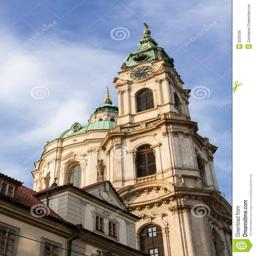

樣本 3: Expert1 預測類别 ancient, Expert2 預測類别 winding, 真實類別 ancient
ancient_building/df7e31262b1d3ce611e6e2c2475cded5.jpg


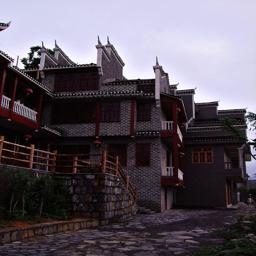

樣本 131: Expert1 預測類别 ancient, Expert2 預測類别 tall, 真實類別 ancient
ancient_tower/ancient_tower_at_night_by_mrgo1-d30n1p0.jpg


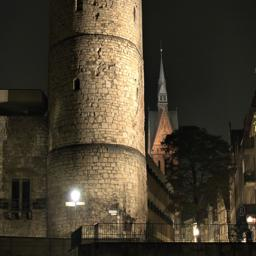

樣本 225: Expert1 預測類别 barren, Expert2 預測類别 murky, 真實類別 barren
barren_creek/20120326_39.jpg


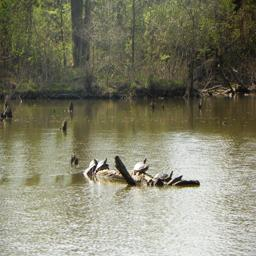

樣本 257: Expert1 預測類别 barren, Expert2 預測類别 frozen, 真實類別 barren
barren_lake/30183615.jpg


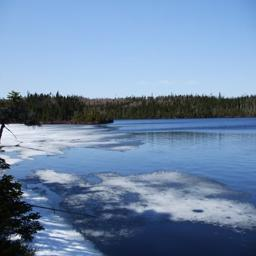

樣本 229: Expert1 預測類别 barren, Expert2 預測類别 murky, 真實類別 barren
barren_creek/BArrenCreek59-600x440.jpg


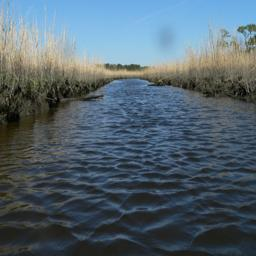

樣本 353: Expert1 預測類别 bent, Expert2 預測類别 thin, 真實類別 bent
bent_blade/12153128084_411d5a85cb_c.jpg


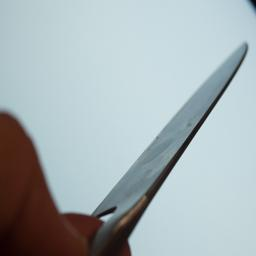

樣本 379: Expert1 預測類别 bent, Expert2 預測類别 blunt, 真實類別 bent
bent_blade/jfmo.jpg


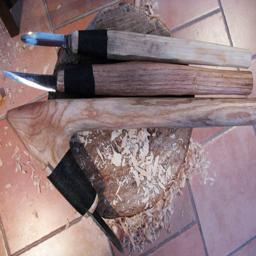

樣本 388: Expert1 預測類别 bent, Expert2 預測類别 sharp, 真實類別 bent
bent_handle/quick-change-tweezers-with-45-degrees-bent-handle-1303-bbr.jpg


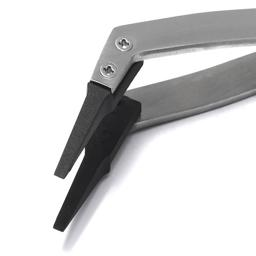

樣本 408: Expert1 預測類别 bright, Expert2 預測類别 cloudy, 真實類別 bright
bright_lightning/2452d11967fd61afe6050a3ca9014855.jpg


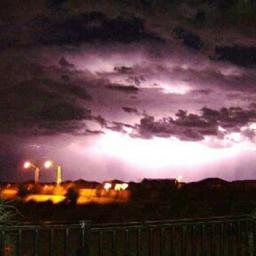

樣本 409: Expert1 預測類别 bright, Expert2 預測類别 steaming, 真實類別 bright
bright_lightning/3608259357_0cac5bd260_z.jpg


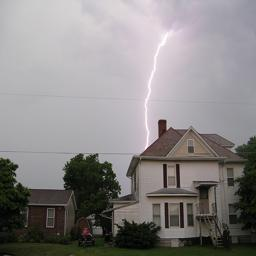

樣本 410: Expert1 預測類别 bright, Expert2 預測類别 molten, 真實類別 bright
bright_lightning/5095816-3x2-940x627.jpg


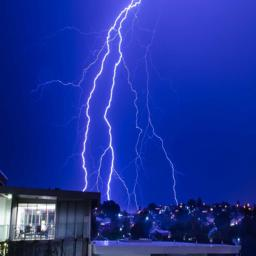

樣本 1029: Expert1 預測類别 brushed, Expert2 預測類别 dark, 真實類別 brushed
brushed_fabric/navy-brushed-mesh-1024x768.jpg


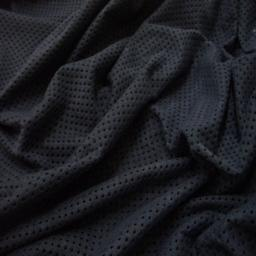

樣本 968: Expert1 預測類别 brushed, Expert2 預測類别 draped, 真實類別 brushed
brushed_copper/original_oversize-brushed-copper-ceiling-shade.jpg


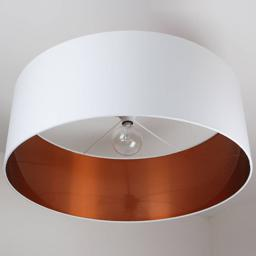

樣本 1000: Expert1 預測類别 brushed, Expert2 預測類别 sharp, 真實類別 brushed
brushed_fabric/100_polyester_tricot_brushed_gold_velvet_fabric.jpg


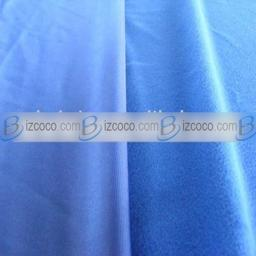

樣本 1218: Expert1 預測類别 burnt, Expert2 預測類别 dark, 真實類別 burnt
burnt_tree/burnt-tree-dalmatian-coast-33853341.jpg


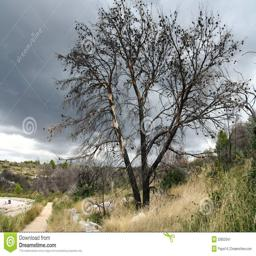

樣本 1091: Expert1 預測類别 burnt, Expert2 預測類别 eroded, 真實類別 burnt
burnt_coal/sw-07280938-0981-BurntCoalDeposits.jpg


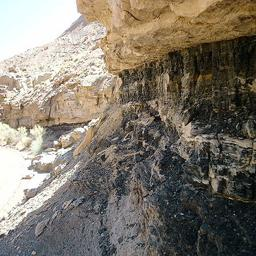

樣本 1128: Expert1 預測類别 burnt, Expert2 預測類别 caramelized, 真實類別 burnt
burnt_oil/022.jpg


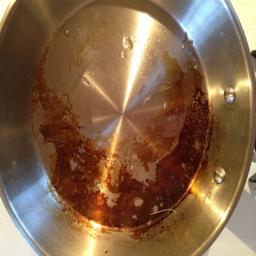

樣本 1377: Expert1 預測類别 caramelized, Expert2 預測類别 small, 真實類別 caramelized
caramelized_tea/Blini-with-Smoked-Rainbow-Trout.jpg


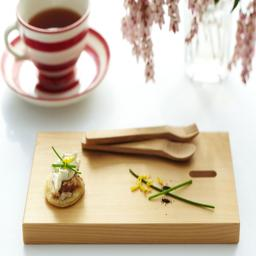

樣本 1285: Expert1 預測類别 caramelized, Expert2 預測類别 splintered, 真實類別 caramelized
caramelized_chocolate/73426ef64c20a315926fa8fc22b5d7af.jpg


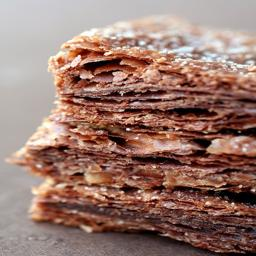

樣本 1294: Expert1 預測類别 caramelized, Expert2 預測類别 browned, 真實類別 caramelized
caramelized_chocolate/IMG_1425-682x10241.jpg


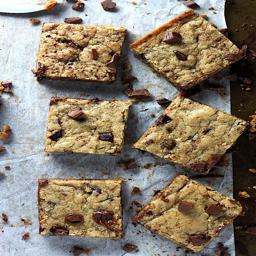

樣本 1506: Expert1 預測類别 clean, Expert2 預測類别 pureed, 真實類別 clean
clean_room/Clean-Room-3-1024x768.jpg


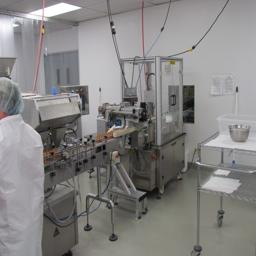

樣本 1534: Expert1 預測類别 clean, Expert2 預測類别 moldy, 真實類別 clean
clean_room/microdisplay-clean-room-32_4.jpg


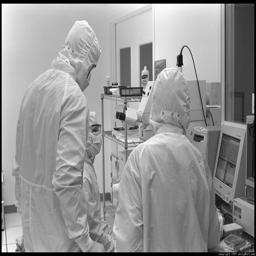

樣本 1511: Expert1 預測類别 clean, Expert2 預測類别 empty, 真實類別 clean
clean_room/Cryopharma-Nov.-82006-006v21.jpg


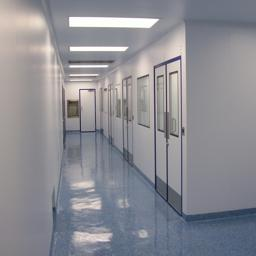

樣本 1705: Expert1 預測類别 cluttered, Expert2 預測類别 mossy, 真實類別 cluttered
cluttered_library/page09.jpg


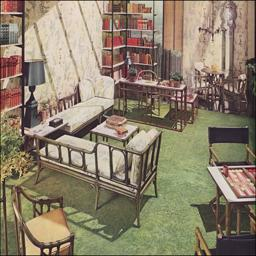

樣本 1654: Expert1 預測類别 cluttered, Expert2 預測類别 pureed, 真實類別 cluttered
cluttered_cabinet/pkn28lazysusan.jpg


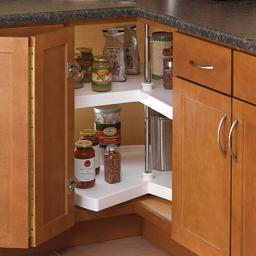

樣本 1920: Expert1 預測類别 coiled, Expert2 預測類别 eroded, 真實類別 coiled
coiled_shell/nga_coiled_shell.jpg


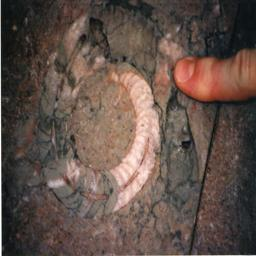

樣本 1795: Expert1 預測類别 coiled, Expert2 預測類别 curved, 真實類別 coiled
coiled_copper/5066d7a8afca4d93471d46133627e566.jpg


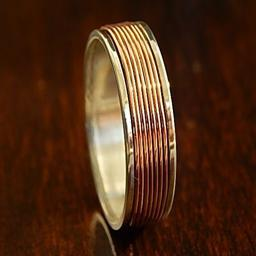

樣本 1734: Expert1 預測類别 coiled, Expert2 預測類别 mossy, 真實類別 coiled
coiled_basket/3d2b760b46c555370f727349baa4b06d.jpg


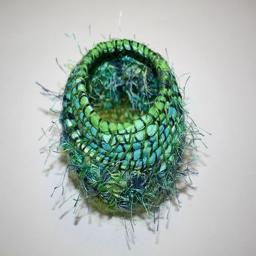

In [110]:
nub_correct_class = 10
print_nub = 3

# 按升序排序錯誤率
error_rates = [(c, (wrong_ep1[c] + wrong_ep2[c]) / (all_attr_gt == c).sum()) for c in range(len(test_dataset.attrs))]
sorted_error_rates = sorted(error_rates, key=lambda x: x[1])

# 输出正確率較高的類別
top_classes = [c for c, _ in sorted_error_rates[:nub_correct_class]]
print("正確率前"+str(nub_correct_class) +"個較高的類别：", [test_dataset.attrs[c] for c in top_classes])

for c in top_classes:
    class_correct_ep1_correct_ep2 = set([i for i in range(len(pred_ep1)) if pred_ep1[i] == all_attr_gt[i] and pred_ep2[i] != all_attr_gt[i] and all_attr_gt[i] == c])
    class_correct_ep1_correct_ep2 = list(class_correct_ep1_correct_ep2)[:print_nub]
    for i in class_correct_ep1_correct_ep2:
        idx = i
        print(f"樣本 {idx}: Expert1 預測類别 {test_dataset.attrs[int(pred_ep1[idx])]}, Expert2 預測類别 {test_dataset.attrs[int(pred_ep2[idx])]}, 真實類別 {test_dataset.attrs[int(all_attr_gt[idx])]}")
        img_path = all_img_path[idx]
        print(img_path)
        img = Image.open(root_path+img_path)
        display(img)

### 計算expected calibration error的Reliability diagram

現在我有logits_attrs_list[0]和logits_attrs_list[1] 他們得維度都是(b,115)  b代表測試圖片的batch size，115代表共有115個屬性數量，這2個變數代表每張圖片屬性機率，現在我想要寫pytorch 計算這兩個變數的每一張圖片的expected calibration error，我要將expected calibration error分別用在logits_attrs_list[0]和logits_attrs_list[1] 上計算，輸出並儲存這2張expected calibration error的Reliability diagram 。 現在我有測試樣本的實際類別all_obj_gt ，dim為(b)，意思就是共有b個測試樣本的實際類別

In [60]:
def compute_ece(probs, targets, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    bin_confidences = []
    bin_accuracies = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (probs >= bin_lower) * (probs < bin_upper)
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            sample_indices = torch.where(torch.any(in_bin, dim=1))[0]
            bin_targets = targets[sample_indices]
            bin_probs = probs[sample_indices]
            true_prob_in_bin = (bin_targets == torch.argmax(bin_probs, dim=1)).float().mean()
            avg_confidence_in_bin = bin_probs[in_bin[sample_indices]].mean()
            ece += torch.abs(avg_confidence_in_bin - true_prob_in_bin) * prop_in_bin
            bin_confidences.append(avg_confidence_in_bin.item())
            bin_accuracies.append(true_prob_in_bin.item())
        else:
            bin_confidences.append(None)
            bin_accuracies.append(None)

    return ece, bin_confidences, bin_accuracies

# logits_attrs_list = [logits_attrs_list[0], logits_attrs_list[1]]
logits_attrs_list = [all_logits.float(), logits_attrs_list[1]]
probs_list = [F.softmax(logits, dim=1) for logits in logits_attrs_list]



In [58]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
def plot_dot_reliability_diagram(ece_value, bin_confidences, bin_accuracies, model_index,test_dataset):
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
    plt.scatter(bin_confidences, bin_accuracies, marker='o', color='blue', label="Model {}".format(model_index + 1))
    plt.xlabel("Confidence", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Reliability Diagram for Model {} (ECE={:.4f})".format(model_index + 1, ece_value.item()), fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    plt.gca().set_axisbelow(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    Path('plt/'+str(len(test_dataset.pairs))).mkdir(parents=True, exist_ok=True)
    plt.savefig('plt/'+str(len(test_dataset.pairs))+'/'+test_dataset.phase+'_'+"dot_reliability_diagram_model_{}.png".format(model_index + 1))

In [ ]:
probs = F.softmax(logits_attrs_list[1], dim=1)
ece_and_bin_values = [compute_ece(probs, all_attr_gt)]
for i, (ece_value, bin_confidences, bin_accuracies) in enumerate(ece_and_bin_values):
    plot_dot_reliability_diagram(ece_value, bin_confidences, bin_accuracies, 1,test_dataset)
probs = F.softmax(all_logits.float(), dim=1)
ece_and_bin_values = [compute_ece(probs, all_pair_gt)]
for i, (ece_value, bin_confidences, bin_accuracies) in enumerate(ece_and_bin_values):
    plot_dot_reliability_diagram(ece_value, bin_confidences, bin_accuracies, 0,test_dataset)

### 繪製混淆矩陣

In [38]:
cm_expert1

array([[75,  1,  0, ...,  0,  0,  0],
       [ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
pred_ep1

In [ ]:
# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, test_dataset,title,):
    plt.figure(figsize=(50, 50))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # 添加文本注释
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.savefig('plt/'+str(len(test_dataset.pairs))+'/'+test_dataset.phase+'_'+ title + '.png')
    plt.show()
b,n_attr =  logits_attrs_list[1].size()
cm_expert1 = confusion_matrix(all_attr_gt.numpy(), pred_ep1.numpy(), labels=np.arange(n_attr))
cm_expert2 = confusion_matrix(all_attr_gt.numpy(), pred_ep2.numpy(), labels=np.arange(n_attr))

# 计算混淆矩阵
cm_expert1 = confusion_matrix(all_attr_gt, pred_ep1, labels=np.arange(n_attr))
# 绘制 expert1 的混淆矩阵
plot_confusion_matrix(cm_expert1,test_dataset ,'Confusion Matrix of Expert1')
# 绘制 expert2 的混淆矩阵
plot_confusion_matrix(cm_expert2,test_dataset ,'Confusion Matrix of Expert2')

In [66]:
'plt/'+str(len(test_dataset.pairs))+'/'+test_dataset.phase+'_confusion_matrix.png'

'plt/28175/test_confusion_matrix.png'

In [ ]:
all_fv_proj_idx = []
for i in range(245):
    fv_proj_idx = 0
    fv_proj_idx = torch.Tensor().cuda()
    for obj_idx in range(len(pairs)):
        if pairs[obj_idx][1] ==i:
            fv_proj_idx = torch.cat([fv_proj_idx, pairs[obj_idx]], dim=0)
    fv_proj_idx=fv_proj_idx.reshape(-1,2)
    all_fv_proj_idx.append(fv_proj_idx) 


### 檢查一下錯誤

In [ ]:
for idx in all_fv_proj_idx:
    a,_=idx.size()
    assert a!=0

### 獲得ft 和batch_obj_idx    ft(1962,768)  batch_obj_idx int

In [28]:
idx_text_features = predict[4]
batch_obj_idx=data[2][0]

### 計算fs|o

In [ ]:
# batch_obj_idx = 0

In [ ]:
fv_proj = 0
fv_proj = torch.Tensor().cuda()
for proj_idx in all_fv_proj_idx[batch_obj_idx]:
    #print(proj_idx)
    index = torch.nonzero(torch.eq(pairs, proj_idx).all(dim=1))
    fv_proj = torch.cat([fv_proj, idx_text_features[index[0]]], dim=0)

In [ ]:
fv_proj.size()

###  計算fs|o在DFSP中

In [ ]:
# batch_obj_idx=obj_idx[0]
# fv_proj = 0
# fv_proj = torch.Tensor().cuda()
# for proj_idx in all_fv_proj_idx[batch_obj_idx]:
#     #print(proj_idx)
#     index = torch.nonzero(torch.eq(pairs, proj_idx).all(dim=1))
#     fv_proj = torch.cat([fv_proj, idx_text_features[index[0]]], dim=0)

### 分解ft>fs,fo

In [28]:
# text_feature=predict[4]
text_feature= torch.rand(1962, 768)  ###先用亂數算

In [29]:
l, c = text_feature.shape
att_idx, obj_idx = pairs[:, 0].cpu().numpy(), pairs[:, 1].cpu().numpy()
text_att = torch.zeros(115, c).cuda()
text_obj = torch.zeros(245, c).cuda()
for i in range(115):
    text_att[ i, :] = text_feature[ np.where(att_idx==i)[0], :].mean(-2)
for i in range(245):
    text_obj[ i, :] = text_feature[ np.where(obj_idx==i)[0], :].mean(-2)    
text_decom_feature = torch.cat([text_att, text_obj], dim=0)

In [30]:
fs = text_decom_feature[:115, :]

In [31]:
fo = text_decom_feature[115:, :]

### 在dfsp 中 獲得ft+>fofs

In [32]:
# ft=fusion.decompose_ftfsfo(idx_text_features,idx)
# fo = text_decom_feature[115:, :]
# fs = text_decom_feature[:115, :]

In [33]:
f_v,_ =DFSP_model.visual(batch_img.type(DFSP_model.clip.dtype))   ## bs * 768
# f_s_given_o = fv_proj
f_s_given_o = torch.rand(10, 768).cuda() ###先用亂數算

In [34]:
f_v.size()

torch.Size([16, 768])

### 更改test速度

In [17]:
def cal_proj_f_v_to_s_given_o(f_v,f_s_given_o):
    # 計算 f_s_given_o 的轉置乘以 f_s_given_o，再取其反矩陣
    temp = torch.matmul(f_s_given_o, f_s_given_o.t()).inverse()
    #最後與 𝑓(𝑠|𝑜)(𝑓_(𝑠|𝑜)^𝑇 𝑓_(𝑠|𝑜))〗^(−1)𝑓(𝑠|𝑜)^T
    temp1 = torch.matmul(f_s_given_o.t(),temp)
    temp2 =torch.matmul(temp1,f_s_given_o)
    # 計算 f_v 與上述結果的乘積，即可得到 f_v->s|o 的轉置
    f_v_to_s_given_o_t = torch.matmul(temp2, f_v.t().float())
    # 轉置回來即為 f_v->s|o
    f_v_to_s_given_o = f_v_to_s_given_o_t.t()
    return f_v_to_s_given_o

In [58]:
gt_obj_idx = data[2]
idx_text_features = torch.rand(1962, 768).cuda()
idx = pairs
f_s_given_o = 0
f_s_given_o = torch.Tensor().cuda()
normalized_img = torch.rand(16, 768).cuda()


In [76]:
proj_f_v_to_s_given_o_finally = torch.Tensor().cuda()
for gt_obj,batch_idx in zip(gt_obj_idx,range(len(gt_obj_idx))):  
    f_s_given_o = torch.Tensor().cuda()
    for proj_idx in all_fv_proj_idx[gt_obj]:       ##假設每個batch的obj都一樣 gt_obj_idx 傳入值是data[2][0]
        index = torch.nonzero(torch.eq(idx, proj_idx).all(dim=1))         
        f_s_given_o = torch.cat([f_s_given_o, idx_text_features[index[0]]], dim=0)   ###獲得fv_proj s|o
#     print(f_s_given_o.size())
#     print(normalized_img[batch_idx].size())
    proj_f_v_to_s_given_o = normalized_img[batch_idx]
    #proj_f_v_to_s_given_o = cal_proj_f_v_to_s_given_o(normalized_img[batch_idx],f_s_given_o)  
    ###第 batch_idx個圖片與f_s_given_o進行計算 ，獲得proj_f_v_to_s_given_o後 concat起來
    ### fv dim(b,768) f(𝑠|𝑜)  dim(?,768)>f(v→s|o)^T dim(b,768)
    proj_f_v_to_s_given_o_finally = torch.cat([proj_f_v_to_s_given_o_finally, proj_f_v_to_s_given_o.unsqueeze(0)] , dim=0)
proj_f_v_to_s_given_o_finally_norm=proj_f_v_to_s_given_o_finally / proj_f_v_to_s_given_o_finally.norm(dim=-1, keepdim=True)

In [72]:
proj_f_v_to_s_given_o_finally_norm.size()

torch.Size([16, 768])

In [70]:
proj_f_v_to_s_given_o_finally.size()

torch.Size([16, 768])

In [78]:
proj_f_v_to_s_given_o_finally_norm.size()

torch.Size([16, 768])

In [77]:
f_s_given_o.size()

torch.Size([9, 768])

In [50]:
proj_f_v_to_s_given_o = cal_proj_f_v_to_s_given_o(f_v,f_s_given_o)

torch.Size([10, 10])
torch.Size([768, 10])
torch.Size([768, 768])
torch.Size([768, 16])


In [45]:
proj_f_v_to_s_given_o.size()

torch.Size([16, 768])

In [ ]:
proj_f_v_to_s_given_o_norm=proj_f_v_to_s_given_o / proj_f_v_to_s_given_o.norm(dim=-1, keepdim=True)

In [20]:
i= 0
with torch.no_grad():
    for idx, data in tqdm(
        enumerate(dataloader), total=len(dataloader), desc="Testing"
    ):
        batch_img = data[0].cuda()
#         predict = DFSP_model(batch_img, pairs,True,data[2].cuda())
        predict = DFSP_model(batch_img, pairs,True,data[2][0],all_fv_proj_idx=all_fv_proj_idx)
        break

Testing:   0%|          | 0/1897 [00:06<?, ?it/s]


In [17]:
i= 0
with torch.no_grad():
    for idx, data in tqdm(
        enumerate(dataloader), total=len(dataloader), desc="Testing"
    ):
        batch_img = data[0].cuda()
        predict = DFSP_model(batch_img, pairs)
        i = i+1
        if i ==2:
            break

Testing:   0%|          | 1/843 [00:07<1:49:19,  7.79s/it]


In [257]:
print(data[1])
print(data[2])
print(data[3])

tensor([0])
tensor([35])
tensor([0])


In [165]:
batch_img = data[0].cuda()
predict_org = DFSP_model(batch_img, pairs)


In [166]:
predict_org[0].size()

torch.Size([128, 1962])

In [167]:
logits_att, logits_obj=DFSP_model.decompose_logits(predict_org[0],pairs)

In [168]:
logits_att.size()

torch.Size([128, 115])

In [169]:
b,_= logits_att.size()

In [170]:
logits_combined = torch.zeros(b,len(pairs))

In [175]:
for i in range(len(pairs)):
    att_idx, obj_idx = pairs[i]
    logits_combined[:, i] = (logits_att[:, att_idx] + logits_obj[:, obj_idx]) 

In [176]:
logits_combined.size()

torch.Size([128, 1962])

In [177]:
logits_combined[0]

tensor([22.3828, 21.7969, 21.3438,  ..., 18.1484, 17.3750, 16.4062],
       grad_fn=<SelectBackward0>)

In [154]:
logits_combined.size()

torch.Size([16, 1962])

In [ ]:
import torch 
from torch.nn import CosineSimilarity


cos_sim = CosineSimilarity(dim=0) 
for i in range(128):
    output= cos_sim(logits_attrs_list[0][i], logits_attrs_list[1][i])
    print(output)
